<center><img src="https://raw.githubusercontent.com/openvinotoolkit/anomalib/main/docs/source/_static/images/logos/anomalib-wide-blue.png" alt="Paris" class="center"></center>

<center>💙 A library for benchmarking, developing and deploying deep learning anomaly detection algorithms</center>

---

> NOTE:
> This notebook is originally created by @innat on [Kaggle](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/notebook).

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

The library supports a number of image and video datasets for **benchmarking** and custom dataset support for **training/inference**. In this notebook, we will explore `anomalib` training a PADIM model on the `MVTec AD` bottle dataset and evaluating the model's performance.


## Installing Anomalib


Installation can be done in two ways: (i) install via PyPI, or (ii) installing from sourc, both of which are shown below:


### I. Install via PyPI


In [1]:
# Option - I: Uncomment the next line if you want to install via pip.
# %pip install anomalib
# %anomalib install -v

> NOTE:
>
> Although v1.0.0 is on PyPI, it may not be stable and may have bugs. It is therefore recommended to install from source.


### II. Install from Source

This option would initially download anomalib repository from github and manually install `anomalib` from source, which is shown below:


In [2]:
# Option - II: Uncomment the next three lines if you want to install from the source.
# !git clone https://github.com/openvinotoolkit/anomalib.git
# %cd anomalib
# %pip install .
# %anomalib install -v

Now let's verify the working directory. This is to access the datasets and configs when the notebook is run from different platforms such as local or Google Colab.


In [3]:
import os
from pathlib import Path

from git.repo import Repo

current_directory = Path.cwd()
if current_directory.name == "000_getting_started":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/000_getting_started/
    root_directory = current_directory.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    repo = Repo.clone_from(
        url="https://github.com/openvinotoolkit/anomalib.git",
        to_path=current_directory,
    )
    root_directory = current_directory / "anomalib"

os.chdir(root_directory)

## Imports


In [4]:
from typing import Any

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage

from anomalib import TaskType
from anomalib.data import MVTec
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer, ExportType
from anomalib.engine import Engine
from anomalib.models import Padim
from anomalib.utils.visualization import ImageResult

## Model

Currently, there are **13** anomaly detection models available in `anomalib` library. Namely,

- [CFA](https://arxiv.org/abs/2206.04325)
- [CS-Flow](https://arxiv.org/abs/2110.02855v1)
- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/main/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [DRAEM](https://arxiv.org/abs/2108.07610)
- [FastFlow](https://arxiv.org/abs/2111.07677)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [Reverse Distillation](https://arxiv.org/abs/2201.10703)
- [R-KDE](https://ieeexplore.ieee.org/document/8999287)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using [Padim](https://arxiv.org/pdf/2011.08785.pdf).


## Dataset: MVTec AD

**MVTec AD** is a dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains over **5000** high-resolution images divided into **15** different object and texture categories. Each category comprises a set of defect-free training images and a test set of images with various kinds of defects as well as images without defects. If the dataset is not located in the root datasets directory, anomalib will automatically install the dataset.

We could now import the MVtec AD dataset using its specific datamodule implemented in anomalib.


In [5]:
datamodule = MVTec(num_workers=0)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(type(data))

<class 'anomalib.dataclasses.torch.ImageBatch'>


Let's check the shapes of the input images and masks.


In [6]:
print(data.image.shape, data.gt_mask.shape)

torch.Size([32, 3, 900, 900]) torch.Size([32, 900, 900])


We could now visualize a normal and abnormal sample from the validation set.


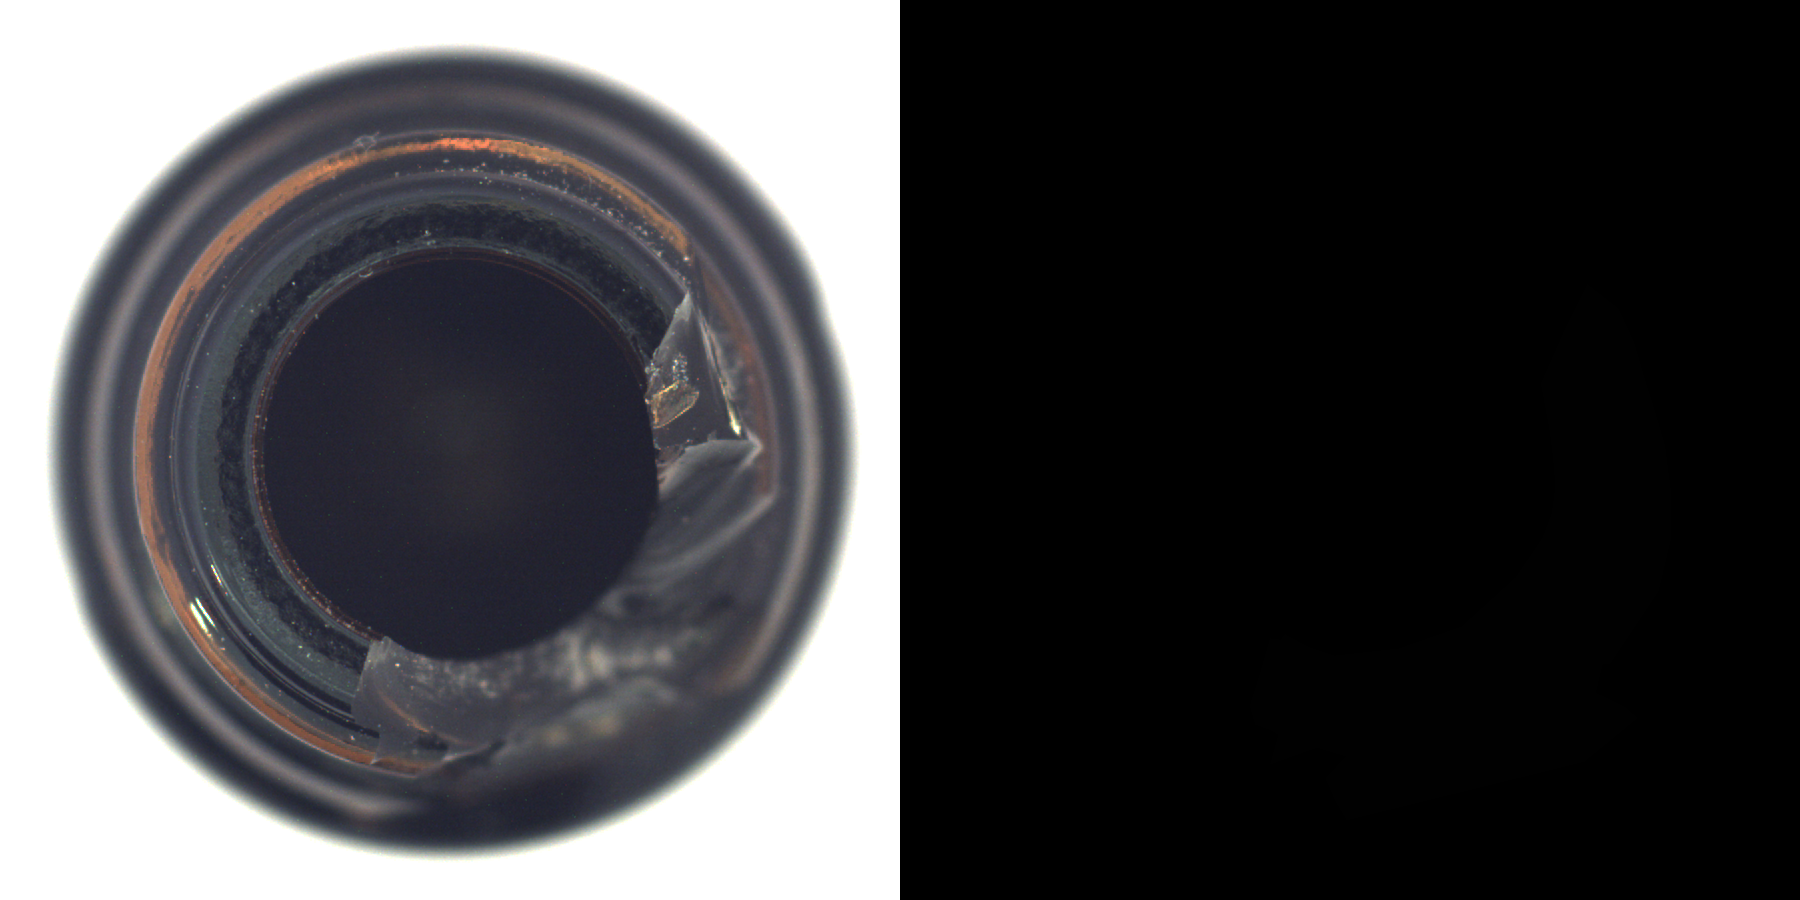

In [7]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    """Show an image with a mask.

    Args:
        sample (dict[str, Any]): Sample from the dataset.
        index (int): Index of the sample.

    Returns:
        Image: Output image with a mask.
    """
    # Load the image from the path
    image = Image.open(sample.image_path[index])

    # Load the mask and convert it to RGB
    mask = ToPILImage()(sample.gt_mask[index].int()).convert("RGB")

    # Resize mask to match image size, if they differ
    if image.size != mask.size:
        mask = mask.resize(image.size)

    return Image.fromarray(np.hstack((np.array(image), np.array(mask))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

## Prepare Model

Let's create the Padim and train it.


In [8]:
# Get the model and datamodule
model = Padim()
datamodule = MVTec(num_workers=0)

In [9]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=datamodule)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/djameln/anomalib/.venv/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no op

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ post_processor │ OneClassPostProcessor    │      0 │ train │
│ 1 │ model          │ PadimModel               │  2.8 M │ train │
│ 2 │ _transform     │ Compose                  │      0 │ train │
│ 3 │ image_metrics  │ AnomalibMetricCollection │      0 │ train │
│ 4 │ pixel_metrics  │ AnomalibMetricCollection │      0 │ train │
└───┴────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11

Output()

/home/djameln/anomalib/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.
/home/djameln/anomalib/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


/home/djameln/anomalib/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/optimization/automatic.py:132: 
`training_step` returned `None`. If this was on purpose, ignore this warning...

`Trainer.fit` stopped: `max_epochs=1` reached.


## Validation


In [10]:
# load best model from checkpoint before evaluating
test_results = engine.test(
    model=model,
    datamodule=datamodule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

Restoring states from the checkpoint path at /home/djameln/anomalib/results/Padim/MVTec/bottle/v5/weights/lightning/model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/djameln/anomalib/results/Padim/MVTec/bottle/v5/weights/lightning/model.ckpt


Output()

/home/djameln/anomalib/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.997619092464447     │
│        image_F1Max        │         0.984375          │
│        pixel_AUROC        │    0.9841534495353699     │
│        pixel_F1Max        │    0.7346382737159729     │
└───────────────────────────┴───────────────────────────┘

In [11]:
print(test_results)

[{'pixel_AUROC': 0.9841534495353699, 'pixel_F1Max': 0.7346382737159729, 'image_AUROC': 0.997619092464447, 'image_F1Max': 0.984375}]


## OpenVINO Inference

Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.


Before we can use OpenVINO inference, let's export the model to OpenVINO format first.


In [12]:
engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
)

/home/djameln/anomalib/.venv/lib/python3.10/site-packages/torch/onnx/utils.py:2078: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  warnings.warn(
/home/djameln/anomalib/src/anomalib/post_processing/one_class.py:151: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  preds = torch.minimum(preds, torch.tensor(1))
/home/djameln/anomalib/src/anomalib/post_processing/one_class.py:152: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  return torch.maximum

PosixPath('/home/djameln/anomalib/results/Padim/MVTec/bottle/latest/weights/openvino/model.xml')

### Load a Test Image

Let's read an image from the test set and perform inference using OpenVINO inferencer.


In [13]:
image_path = root_directory / "datasets/MVTec/bottle/test/broken_large/000.png"
image = read_image(path="./datasets/MVTec/bottle/test/broken_large/000.png")
plt.imshow(image)

### Load the OpenVINO Model

By default, the output files are saved into `results` directory. Let's check where the OpenVINO model is stored.


In [14]:
output_path = Path(engine.trainer.default_root_dir)
print(output_path)

/home/djameln/anomalib/results/Padim/MVTec/bottle/latest


In [15]:
openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
print(openvino_model_path.exists())

True


In [16]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### Perform Inference

Predicting an image using OpenVINO inferencer is as simple as calling `predict` method.


In [17]:
predictions = inferencer.predict(image=image_path)
predictions = ImageResult.from_dataset_item(predictions.items[0])  # convert to imageresult for visualization

where `predictions` contain any relevant information regarding the task type. For example, predictions for a segmentation model could contain image, anomaly maps, predicted scores, labels or masks.


### Visualizing Inference Results


In [18]:
print(predictions.pred_score, predictions.pred_label)

0.7244761 [ True]


In [19]:
# Visualize the original image
plt.imshow(predictions.image)

In [20]:
# Visualize the raw anomaly maps predicted by the model.
plt.imshow(predictions.anomaly_map)

In [21]:
# Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
plt.imshow(predictions.heat_map)

In [22]:
# Visualize the segmentation mask.
plt.imshow(predictions.pred_mask)

In [23]:
# Visualize the segmentation mask with the original image.
plt.imshow(predictions.segmentations)

This wraps the `getting_started` notebook. There are a lot more functionalities that could be explored in the library. Please refer to the [documentation](https://openvinotoolkit.github.io/anomalib/) for more details.
